In [1]:
import time
import os
from tqdm import tqdm

import pandas as pd
import numpy as np
import cv2
import seaborn as sns
from PIL import Image

import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
import torch
import torchvision
import torch.nn as nn
import torch.nn.functional as F

In [3]:
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
from torchvision import transforms
import torch.optim as optim
import os

In [4]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print('device', device)

device cuda:0


In [5]:
train_dataset_csv = pd.read_csv('Train_Data.csv')
# cv_dataset = pd.read_csv('CV_Data.csv')
# test_dataset = pd.read_csv('Test_Data.csv')

In [6]:
# print(type(train_dataset_csv))
# print(len(train_dataset_csv))
# train_dataset_csv.head()

# 字典生成

In [6]:
CaptionWordAll = []
CaptionWordLength = []
for idx,data_ in enumerate(train_dataset_csv.iterrows()):
#     print(data_)
    print(data_[1])
    break

Person_id            ../data/NLMCXR/NLMCXR_png/CXR1_1_IM-0001_0
Image1        ../data/NLMCXR/NLMCXR_png/CXR1_1_IM-0001-3001.png
Image2        ../data/NLMCXR/NLMCXR_png/CXR1_1_IM-0001-4001.png
Report        the cardiac silhouette and mediastinum size ar...
Impression                                         normal chest
Name: 0, dtype: object


In [91]:
CaptionWordAll = []
CaptionWordLength = []
for idx,data_ in enumerate(train_dataset_csv.iterrows()):
    caption = data_[1][3]
    CaptionWordLength.append(len(caption.split(' ')))
    CaptionWordAll.extend(caption.split(' '))

print('平均句子长度为：',np.mean(CaptionWordLength))
print('最大句子长度为：',np.max(CaptionWordLength))
print('最小句子长度为：',np.min(CaptionWordLength))

print('单词总量为：',len(CaptionWordAll))
print('字典长度为：',len(set(CaptionWordAll)))

# 100

from collections import Counter
# 统计频率，按照从高到底排序，这样构建的字典使用频率最高的符号在最前面，查找起来快
counts = Counter(CaptionWordAll)
count_sorted = counts.most_common()
count_sorted_ = {k: v for k, v in count_sorted if v > 1}

# 构造字典
# 增加 <pad> 0 <unk> 1 <start> 2 <end> 3  四个作为常用符号

word2id_dict={'<pad>':0,'<unk>':1,'<start>':2,'<end>':3}
id2word_dict={0:'<pad>',1:'<unk>',2:'<start>',3:'<end>'}

for idx,item in enumerate(count_sorted_):
    idx_ = idx+4 # 预留四个做为记录
    item_ = item
    word2id_dict[item_] = idx_
    id2word_dict[idx_] = item_

len_dict=len(word2id_dict)
# 删除只出现一次的单词
print('修正后字典长度为：',len_dict)

平均句子长度为： 36.25924583031182
最大句子长度为： 169
最小句子长度为： 7
单词总量为： 100003
字典长度为： 1423
修正后字典长度为： 989


In [90]:
word2id_dict

{'<pad>': 0,
 '<unk>': 1,
 '<start>': 2,
 '<end>': 3,
 '.': 4,
 '': 5,
 'the': 6,
 'no': 7,
 'are': 8,
 'normal': 9,
 'and': 10,
 'pleural': 11,
 'there': 12,
 'pneumothora': 13,
 'effusion': 14,
 'heart': 15,
 'lungs': 16,
 'size': 17,
 'focal': 18,
 'within': 19,
 'clear': 20,
 'limits': 21,
 'pulmonary': 22,
 'consolidation': 23,
 'silhouette': 24,
 'right': 25,
 'mediastinal': 26,
 'airspace': 27,
 'cardiomediastinal': 28,
 'left': 29,
 'acute': 30,
 'lung': 31,
 'with': 32,
 'unremarkable': 33,
 'disease': 34,
 'stable': 35,
 'spine': 36,
 'mediastinum': 37,
 'structures': 38,
 'changes': 39,
 'contours': 40,
 'thoracic': 41,
 'bony': 42,
 'contour': 43,
 'mild': 44,
 'degenerative': 45,
 'large': 46,
 'seen': 47,
 'appear': 48,
 'opacity': 49,
 'osseous': 50,
 'without': 51,
 'calcified': 52,
 'cardiac': 53,
 'effusions': 54,
 'vascularity': 55,
 'intact': 56,
 'abnormality': 57,
 'for': 58,
 'visualized': 59,
 'opacities': 60,
 'evidence': 61,
 'upper': 62,
 'lateral': 63,
 'vas

In [8]:
class DatasetFromCSV(Dataset):
    def __init__(self, csv_path,word2id_dict,maxlength = 40):
        # 读取csv文件
        self.data_info = pd.read_csv(csv_path)# 去掉header=None，会读取表头
        #第一列为person_id，以下都为一个列表
        self.person_id = np.asarray(self.data_info.iloc[:, 0])
        self.image1 = np.asarray(self.data_info.iloc[:,1])
        self.image2 = np.asarray(self.data_info.iloc[:,2])
        self.report = np.asarray(self.data_info.iloc[:,3])
        self.impression = np.asarray(self.data_info.iloc[:,3])
        # 长度，train=2758
        self.data_len = len(self.data_info.index)
        
#         self.mode = mode
        self.w2i_dict = word2id_dict
        self.maxlength = maxlength # 输入的最长字符数
        self.padid = 0 # 0为填充符号
#         self.h5f = h5f #暂时去掉文件
        
        

    def __getitem__(self, index):
        singel_person_id=self.person_id[index]
        singel_image1=Image.open(self.image1[index])
        singel_image2=Image.open(self.image2[index])
        singel_report=self.report[index]
        singel_impression=self.impression[index]
        transf=transforms.Compose([transforms.Resize((224,224)),
                                   transforms.ToTensor(),
                                  ])
        singel_image1=transf(singel_image1)
        singel_image2=transf(singel_image2)
        ##把图片标签也变成tensor类型
#         singel_report=torch.tensor(singel_report)

#         # Transform image to tensor
#         img_as_tensor = self.to_tensor(img_as_img)
#         # Get label of the image based on the cropped pandas column
#         single_image_label = self.label_arr[index]
#         return singel_person_id,singel_image1

        # 输入转成idx
    
        return [singel_image1,singel_image2], singel_report,singel_impression, singel_person_id

    def __len__(self):
        return self.data_len
    
    
#     def generIdxList(self,tdata):
#     # 从输入的String中，生成idx的List
#         data = tdata.split(' ')
#         data_out = []
#         # 限制长度，输入'<start>' 和 '<end>'
#         data = ['<start>'] + data 

#         if len(data)>self.maxlength-1:
#             data = data[:self.maxlength-1] # 留一个位置给'<end>
#             data = data + ['<end>']

#         else:
#             # 占位符
#             occupy_ = ['<pad>'] * (self.maxlength - 1 - len(data))
#             data = data + ['<end>']
#             data = data + occupy_

#         # word 2 index
#         for word in data:

#             if self.w2i_dict.get(word)!= None: # 能找到word
#                 id_ = self.w2i_dict[word]
#                 data_out.append(id_)
#             else:
#                 id_ = self.w2i_dict['<unk>']
#                 data_out.append(id_)

#         length = len(data_out)-1

#         return data_out,length

In [9]:
train_dataset = DatasetFromCSV('Train_Data.csv',word2id_dict)
cv_dataset = DatasetFromCSV('CV_Data.csv',word2id_dict)
test_dataset = DatasetFromCSV('Test_Data.csv',word2id_dict)

In [10]:
# train_dataset[1]

In [11]:
train_loader=DataLoader(dataset=train_dataset,
                        batch_size=16,
                        shuffle=False,#!!
                        drop_last=True,#!因为Expected input batch_size (4) to match target batch_size (16).错误的原因，暂时修改为TRUE
                        num_workers=0)

In [12]:
test_loader=DataLoader(dataset=test_dataset,
                        batch_size=16,
                        shuffle=True,
                        drop_last=True,
                        num_workers=0)
cv_loader=DataLoader(dataset=cv_dataset,
                        batch_size=16,
                        shuffle=True,
                        drop_last=True,
                        num_workers=0)

In [13]:
import clip

clip.available_models()

['RN50',
 'RN101',
 'RN50x4',
 'RN50x16',
 'RN50x64',
 'ViT-B/32',
 'ViT-B/16',
 'ViT-L/14',
 'ViT-L/14@336px']

In [14]:
clip_model, preprocess = clip.load("ViT-B/32",device=device,jit=False,)
# model.cuda().eval()
input_resolution =clip_model.visual.input_resolution
context_length = clip_model.context_length
vocab_size = clip_model.vocab_size

print("Model parameters:", f"{np.sum([int(np.prod(p.shape)) for p in clip_model.parameters()]):,}")
print("Input resolution:", input_resolution)
print("Context length:", context_length)
print("Vocab size:", vocab_size)

Model parameters: 151,277,313
Input resolution: 224
Context length: 77
Vocab size: 49408


In [15]:
preprocess

Compose(
    Resize(size=224, interpolation=bicubic, max_size=None, antialias=None)
    CenterCrop(size=(224, 224))
    <function _convert_image_to_rgb at 0x000001D19D72F700>
    ToTensor()
    Normalize(mean=(0.48145466, 0.4578275, 0.40821073), std=(0.26862954, 0.26130258, 0.27577711))
)

In [16]:
clip_model

CLIP(
  (visual): VisionTransformer(
    (conv1): Conv2d(3, 768, kernel_size=(32, 32), stride=(32, 32), bias=False)
    (ln_pre): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
    (transformer): Transformer(
      (resblocks): Sequential(
        (0): ResidualAttentionBlock(
          (attn): MultiheadAttention(
            (out_proj): NonDynamicallyQuantizableLinear(in_features=768, out_features=768, bias=True)
          )
          (ln_1): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
          (mlp): Sequential(
            (c_fc): Linear(in_features=768, out_features=3072, bias=True)
            (gelu): QuickGELU()
            (c_proj): Linear(in_features=3072, out_features=768, bias=True)
          )
          (ln_2): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        )
        (1): ResidualAttentionBlock(
          (attn): MultiheadAttention(
            (out_proj): NonDynamicallyQuantizableLinear(in_features=768, out_features=768, bias=True)
          

In [30]:
train_dataset_csv['Impression']

0                                            normal chest
1                     no acute cardiopulmonary process . 
2                                    no active disease . 
3       increased opacity the right upper lobe with as...
4       increased opacity the right upper lobe with as...
                              ...                        
2753         stable cardiomegaly without acute disease . 
2754                                  no acute disease . 
2755              no acute cardiopulmonary abnormality . 
2756              no acute cardiopulmonary abnormality . 
2757              no acute cardiopulmonary abnormality . 
Name: Impression, Length: 2758, dtype: object

In [9]:
labels = []
for i in range(len(train_dataset_csv['Impression'])):
    if  'normal' in train_dataset_csv['Impression'][i] :
        labels.append('normal chest')
    elif 'no 'in train_dataset_csv['Impression'][i] :
        labels.append('normal chest')
    elif 'negative'in train_dataset_csv['Impression'][i] :
        labels.append('normal chest')
    elif 'without'in train_dataset_csv['Impression'][i] :
        labels.append('normal chest')
    else:
        labels.append(train_dataset_csv['Impression'][i])

In [21]:
labels16=labels[0:16]

In [18]:
i=0
for batch in train_loader:
    i=i+1
    images, report, impression, person_id = batch
    image1 = images[0].to(device)
    image2 = images[1].to(device)
    impression_token = clip.tokenize(texts=labels16, truncate=True).to(device)
    
    with torch.no_grad():
#         image_features = clip_model.encode_image(image1).float()
        image_features = clip_model.encode_image(image2).float()
        text_features = clip_model.encode_text(impression_token).float()
    if i==1:
        break

NameError: name 'labels16' is not defined

In [25]:
image_features /= image_features.norm(dim=-1, keepdim=True)
text_features /= text_features.norm(dim=-1, keepdim=True)
similarity = text_features.cpu().numpy() @ image_features.cpu().numpy().T

In [26]:
similarity

array([[0.27615744, 0.26567483, 0.25815985, 0.26614946, 0.26950717,
        0.26950717, 0.2440412 , 0.27358896, 0.23377103, 0.28119987,
        0.26652336, 0.26058757, 0.27461338, 0.27461338, 0.2688269 ,
        0.24772197],
       [0.27615744, 0.26567483, 0.25815985, 0.26614946, 0.26950717,
        0.26950717, 0.2440412 , 0.27358896, 0.23377103, 0.28119987,
        0.26652336, 0.26058757, 0.27461338, 0.27461338, 0.2688269 ,
        0.24772197],
       [0.27615744, 0.26567483, 0.25815985, 0.26614946, 0.26950717,
        0.26950717, 0.2440412 , 0.27358896, 0.23377103, 0.28119987,
        0.26652336, 0.26058757, 0.27461338, 0.27461338, 0.2688269 ,
        0.24772197],
       [0.30050403, 0.28929242, 0.28065234, 0.28610316, 0.29475975,
        0.29475975, 0.2641968 , 0.30579394, 0.2855647 , 0.29886913,
        0.28992143, 0.28380862, 0.30585423, 0.30585423, 0.2857641 ,
        0.28339317],
       [0.30050403, 0.28929242, 0.28065234, 0.28610316, 0.29475975,
        0.29475975, 0.2641968 , 

Text(0.5, 1.0, 'Cosine similarity between text and image features')

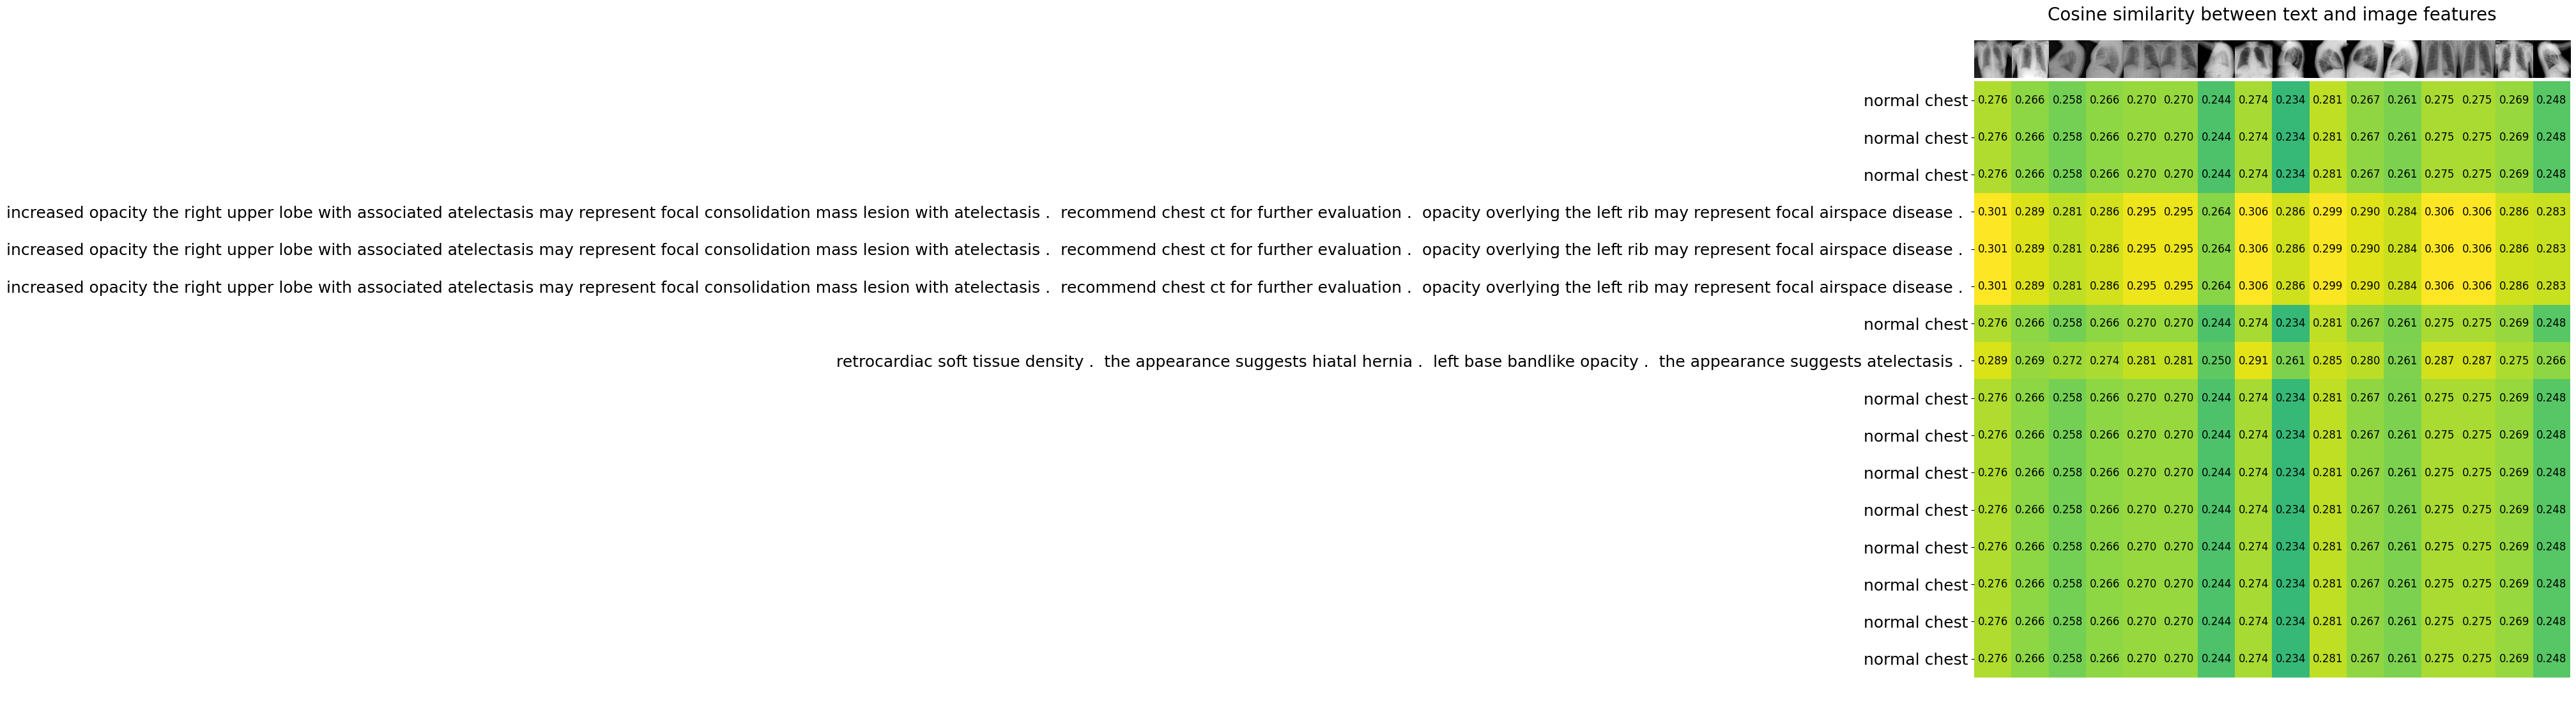

In [30]:
count = len(impression)

plt.figure(figsize=(20, 14))
plt.imshow(similarity, vmin=0.1, vmax=0.3)
# plt.colorbar()
plt.yticks(range(count), labels16, fontsize=18)
plt.xticks([])
for i, image in enumerate(image2):
    plt.imshow(image.cpu().numpy().transpose(1,2,0), extent=(i - 0.5, i + 0.5, -1.6, -0.6), origin="lower")
for x in range(similarity.shape[1]):
    for y in range(similarity.shape[0]):
        plt.text(x, y, f"{similarity[y, x]:.3f}", ha="center", va="center", size=12)

for side in ["left", "top", "right", "bottom"]:
    plt.gca().spines[side].set_visible(False)

plt.xlim([-0.5, count - 0.5])
plt.ylim([count + 0.5, -2])

plt.title("Cosine similarity between text and image features", size=20)

# 提取图像特征

In [31]:
train_dataset_csv.head()

,Person_id,Image1,Image2,Report,Impression
0,../data/NLMCXR/NLMCXR_png/CXR1_1_IM-0001_0,../data/NLMCXR/NLMCXR_png/CXR1_1_IM-0001-3001.png,../data/NLMCXR/NLMCXR_png/CXR1_1_IM-0001-4001.png,the cardiac silhouette and mediastinum size ar...,normal chest
1,../data/NLMCXR/NLMCXR_png/CXR10_IM-0002_0,../data/NLMCXR/NLMCXR_png/CXR10_IM-0002-1001.png,../data/NLMCXR/NLMCXR_png/CXR10_IM-0002-2001.png,the cardiomediastinal silhouette within normal...,no acute cardiopulmonary process .
2,../data/NLMCXR/NLMCXR_png/CXR100_IM-0002_0,../data/NLMCXR/NLMCXR_png/CXR100_IM-0002-1001.png,../data/NLMCXR/NLMCXR_png/CXR100_IM-0002-2001.png,both lungs are clear and epanded . heart and ...,no active disease .
3,../data/NLMCXR/NLMCXR_png/CXR1000_IM-0003_0,../data/NLMCXR/NLMCXR_png/CXR1000_IM-0003-1001...,../data/NLMCXR/NLMCXR_png/CXR1000_IM-0003-2001...,there increased opacity within the right upper...,increased opacity the right upper lobe with as...
4,../data/NLMCXR/NLMCXR_png/CXR1000_IM-0003_1,../data/NLMCXR/NLMCXR_png/CXR1000_IM-0003-1001...,../data/NLMCXR/NLMCXR_png/CXR1000_IM-0003-3001...,there increased opacity within the right upper...,increased opacity the right upper lobe with as...


In [32]:
import h5py

In [33]:
save_path = '../../CLIP-out/h5/'

In [45]:
if not os.path.exists(save_path):
    os.makedirs(save_path)
    
h5f1 = h5py.File(os.path.join(save_path,'train_clip_features1.h5'), 'w')
h5f2 = h5py.File(os.path.join(save_path,'train_clip_features2.h5'), 'w')
i=0
for batch in train_loader:
    i=i+1
    images, report, impression, person_id = batch
    image1 = images[0].to(device)
    image2 = images[1].to(device)
    report_token = clip.tokenize(texts=report, truncate=True).to(device)
    with torch.no_grad():
        image_features1 = clip_model.encode_image(image1).float()
        image_features2 = clip_model.encode_image(image2).float()
        data1 = image_features1.cpu().numpy().astype('float32')
        data2 = image_features2.cpu().numpy().astype('float32')
        for idx in range(train_loader.batch_size):
            save_path_h51 = data1[idx]
            save_path_h52 = data2[idx]
    #         h5f1.create_dataset(orie_fin + '_' + item_fin, data=save_path_h51)
    #         h5f2.create_dataset(orie_fin + '_' + item_fin, data=save_path_h52)
            h5f1.create_dataset(''.join(person_id[idx]), data=save_path_h51)
            h5f2.create_dataset(''.join(person_id[idx]), data=save_path_h52)
        
#         text_features = clip_model.encode_text(report_token).float()
h5f1.close()
h5f2.close()

In [43]:
# save_path = '../../CLIP-out/h5/'
if not os.path.exists(save_path):
    os.makedirs(save_path)
    
cv_h5f1 = h5py.File(os.path.join(save_path,'cv_clip_features1.h5'), 'w')
cv_h5f2 = h5py.File(os.path.join(save_path,'cv_clip_features2.h5'), 'w')
i=0
for batch in cv_loader:
    i=i+1
    images, report, impression, person_id = batch
    image1 = images[0].to(device)
    image2 = images[1].to(device)
    report_token = clip.tokenize(texts=report, truncate=True).to(device)
    with torch.no_grad():
        image_features1 = clip_model.encode_image(image1).float()
        image_features2 = clip_model.encode_image(image2).float()
        data1 = image_features1.cpu().numpy().astype('float32')
        data2 = image_features2.cpu().numpy().astype('float32')

        for idx in range(cv_loader.batch_size):
            save_path_h51 = data1[idx]
            save_path_h52 = data2[idx]
    #         h5f1.create_dataset(orie_fin + '_' + item_fin, data=save_path_h51)
    #         h5f2.create_dataset(orie_fin + '_' + item_fin, data=save_path_h52)
            cv_h5f1.create_dataset(''.join(person_id[idx]), data=save_path_h51)
            cv_h5f2.create_dataset(''.join(person_id[idx]), data=save_path_h52)
#         text_features = clip_model.encode_text(report_token).float()
cv_h5f1.close()
cv_h5f2.close()

In [35]:
test_h5f1.close()
test_h5f2.close()
test_h5f1

<Closed HDF5 file>

In [36]:
# save_path = '../../CLIP-out/h5/'
# if not os.path.exists(save_path):
#     os.makedirs(save_path)
    
test_h5f1 = h5py.File(os.path.join(save_path+'test_clip_features1.h5'), 'w')
test_h5f2 = h5py.File(os.path.join(save_path+'test_clip_features2.h5'), 'w')
i=0
for batch in test_loader:
    i=i+1
    images, report, impression, person_id = batch
    image1 = images[0].to(device)
    image2 = images[1].to(device)
    report_token = clip.tokenize(texts=report, truncate=True).to(device)
    with torch.no_grad():
        image_features1 = clip_model.encode_image(image1).float()
        image_features2 = clip_model.encode_image(image2).float()
        data1 = image_features1.cpu().numpy().astype('float32')
        data2 = image_features2.cpu().numpy().astype('float32')
        
        for idx in range(test_loader.batch_size):
            save_path_h51 = data1[idx]
            save_path_h52 = data2[idx]
    #         h5f1.create_dataset(orie_fin + '_' + item_fin, data=save_path_h51)
    #         h5f2.create_dataset(orie_fin + '_' + item_fin, data=save_path_h52)
            test_h5f1.create_dataset(''.join(person_id[idx]), data=save_path_h51)
            test_h5f2.create_dataset(''.join(person_id[idx]), data=save_path_h52)
        
#         text_features = clip_model.encode_text(report_token).float()
test_h5f1.close()
test_h5f2.close()

In [74]:
import h5py
h5f1 = h5py.File(os.path.join(save_path+'train_clip_features1.h5'), 'r')
h5f2 = h5py.File(os.path.join(save_path+'train_clip_features2.h5'), 'r')
train_feature = h5f1['../data/NLMCXR/NLMCXR_png/CXR1_1_IM-0001_0'] # 第一个下划线 之前为图片朝向，之后为图像原命名
print(np.array(train_feature).shape) # 每个图片保存为一个{{512}}维度的向量
h5f1.close() 
h5f2.close()

(512,)


In [20]:
i=0
for batch in train_loader:
    i=i+1
    images, report, impression, person_id = batch
    image1 = images[0].to(device)
    image2 = images[1].to(device)
    report_token = clip.tokenize(texts=report, truncate=True).to(device)
    
    with torch.no_grad():
#         image_features = clip_model.encode_image(image1).float()
        image_features = clip_model.encode_image(image2).float()
        text_features = clip_model.encode_text(report_token).float()
    if i==1:
        break

# 新数据集

In [14]:
import h5py

class CaptionDataset(Dataset):
    def __init__(self, csv_path,word2id_dict,h5f1,h5f2,maxlength = 40):
        # 读取csv文件
        self.data_info = pd.read_csv(csv_path)# 去掉header=None，会读取表头
        #第一列为person_id，以下都为一个列表
        self.person_id = np.asarray(self.data_info.iloc[:, 0])
        self.image1 = np.asarray(self.data_info.iloc[:,1])
        self.image2 = np.asarray(self.data_info.iloc[:,2])
        self.report = np.asarray(self.data_info.iloc[:,3])
        self.impression = np.asarray(self.data_info.iloc[:,3])
        # 长度，train=2758
        self.data_len = len(self.data_info.index)
        
#         self.mode = mode
        self.w2i_dict = word2id_dict
        self.maxlength = maxlength # 输入的最长字符数
        self.padid = 0 # 0为填充符号
        self.h5f1 = h5f1
        self.h5f2 = h5f2
        

    def __getitem__(self, index):
        singel_person_id=self.person_id[index]
        singel_image1=Image.open(self.image1[index])
        singel_image2=Image.open(self.image2[index])
        singel_report=self.report[index]
        singel_impression=self.impression[index]
        transf=transforms.Compose([transforms.Resize((224,224)),
                                   transforms.ToTensor(),
                                  ])
        singel_image1=transf(singel_image1)
        singel_image2=transf(singel_image2)

        # 读取图像的特征
        img_feature1 = np.array(self.h5f1[singel_person_id]) # 第一个下划线 之前为图片朝向，之后为图像原命名

        # 输入转成idx
        trg,trg_length = self.generIdxList(singel_report) # data

        return img_feature1,trg,trg_length,singel_person_id,[singel_image1,singel_image2], singel_report,singel_impression #特征，
    
#         return [singel_image1,singel_image2], singel_report,singel_impression, singel_person_id

    def __len__(self):
        return self.data_len
    
    
    def generIdxList(self,tdata):
    # 从输入的String中，生成idx的List
        data = tdata.split(' ')
        data_out = []
        # 限制长度，输入'<start>' 和 '<end>'
        data = ['<start>'] + data 

        if len(data)>self.maxlength-1:
            data = data[:self.maxlength-1] # 留一个位置给'<end>
            data = data + ['<end>']

        else:
            # 占位符
            occupy_ = ['<pad>'] * (self.maxlength - 1 - len(data))
            data = data + ['<end>']
            data = data + occupy_

        # word 2 index
        for word in data:

            if self.w2i_dict.get(word)!= None: # 能找到word
                id_ = self.w2i_dict[word]
                data_out.append(id_)
            else:
                id_ = self.w2i_dict['<unk>']
                data_out.append(id_)

        length = len(data_out)-1

        return data_out,length

def stackInput(inputs):

    img_features1 = np.stack([inputsub[0] for inputsub in inputs], axis=0)
    trg = np.stack([inputsub[1] for inputsub in inputs], axis=0)
    trg_length = np.stack([inputsub[2] for inputsub in inputs], axis=0)

#     trg_mask =(trg[:,:-1]!=0).astype(torch.get_default_dtype())
    trg_mask =torch.from_numpy((trg[:,:-1]!=0)).float()
    trg_ = trg[:,1:] # 将start标记更改为 imgfeatures
    
    img_features1=torch.from_numpy(img_features1)
    trg_length=torch.from_numpy(trg_length)
    trg_=torch.from_numpy(trg_)
    trg=torch.from_numpy(trg)
    
    
    return img_features1,trg_length,trg_[:,:-1],trg[:,1:,np.newaxis],trg_mask
    

In [15]:
save_path = '../../CLIP-out/h5/'
train_h5f1 = h5py.File(os.path.join(save_path+'train_clip_features1.h5'), 'r')
train_h5f2 = h5py.File(os.path.join(save_path+'train_clip_features2.h5'), 'r')

cv_h5f1 = h5py.File(os.path.join(save_path+'cv_clip_features1.h5'), 'r')
cv_h5f2 = h5py.File(os.path.join(save_path+'cv_clip_features2.h5'), 'r')

train_dataset = CaptionDataset('Train_Data.csv',word2id_dict,train_h5f1,train_h5f2)
cv_dataset = CaptionDataset('CV_Data.csv',word2id_dict,cv_h5f1,cv_h5f2)
# test_dataset = DatasetFromCSV('Test_Data.csv',word2id_dict)

In [16]:
train_loader=DataLoader(dataset=train_dataset,
                        batch_size=16,
                        shuffle=False,#!!
                        drop_last=True,#!因为Expected input batch_size (4) to match target batch_size (16).错误的原因，暂时修改为TRUE
                        num_workers=0,
                        collate_fn = stackInput)
cv_loader=DataLoader(dataset=cv_dataset,
                    batch_size=16,
                    shuffle=False,#!!
                    drop_last=True,#!因为Expected input batch_size (4) to match target batch_size (16).错误的原因，暂时修改为TRUE
                    num_workers=0,
                    collate_fn = stackInput,)

#  构建模型

In [45]:
class CaptionModel(nn.Module):

    def __init__(self, vocab_size,embedding_dim,hidden_size,num_layers,word2id_dict,id2word_dict):
        
        super(CaptionModel,self).__init__()

        self.hidden_size=hidden_size
        self.num_layers=num_layers        
        self.fc = torch.nn.Linear(512,embedding_dim)
        self.embedding=torch.nn.Embedding(vocab_size,embedding_dim)
        #lstm层
        self.rnn=torch.nn.LSTM (input_size=embedding_dim,
                                hidden_size=hidden_size,
                                num_layers=num_layers)
        self.word2ix = word2id_dict
        self.ix2word = id2word_dict
        #全连接层
        self.classifier = torch.nn.Linear(hidden_size,vocab_size)

    def forward(self,img_features,trg,trg_length):
        img_features = torch.unsqueeze(self.fc(img_features),axis = 1)
        embeddings = self.embedding(trg)
        inputs = torch.concat([img_features,embeddings],axis = 1)
#         outputs,state = self.rnn(inputs,sequence_length = trg_length)
        outputs,state = self.rnn(inputs)
        predict = self.classifier(outputs)

        return predict

    def generate(self, img_feat, eos_token='<end>',
                 beam_size=2,
                 max_caption_length=40,
                 length_normalization_factor=0.0):
        """
        根据图片生成描述,主要是使用beam search算法以得到更好的描述
        """
        cap_gen = CaptionGenerator(embedder=self.embedding,
                                   rnn=self.rnn,
                                   classifier=self.classifier,
                                   eos_id=self.word2ix[eos_token],
                                   beam_size=beam_size,
                                   max_caption_length=max_caption_length,
                                   length_normalization_factor=length_normalization_factor)

        
        img_feat = torch.unsqueeze(img_feat,axis = 0)
        img = torch.unsqueeze(self.fc(img_feat),axis = 0)
        img=img.to(device)
        cap_gen=cap_gen.to(device)
        sentences, score = cap_gen.beam_search(img)
        
        sentences = [' '.join([self.ix2word[int(idx)] for idx in sent])
                     for sent in sentences]
        return sentences

In [46]:
# Beam Search
import heapq

class TopN(object):
    """Maintains the top n elements of an incrementally provided set."""

    def __init__(self, n):
        self._n = n
        self._data = []

    def size(self):
        assert self._data is not None
        return len(self._data)

    def push(self, x):
        """Pushes a new element."""
        assert self._data is not None
        if len(self._data) < self._n:
            heapq.heappush(self._data, x)
        else:
            heapq.heappushpop(self._data, x)

    def extract(self, sort=False):
        """
        Extracts all elements from the TopN. This is a destructive operation.
        The only method that can be called immediately after extract() is reset().
        Args:
          sort: Whether to return the elements in descending sorted order.
        Returns:
          A list of data; the top n elements provided to the set.
        """
        assert self._data is not None
        data = self._data
        self._data = None
        if sort:
            data.sort(reverse=True)
        return data

    def reset(self):
        """Returns the TopN to an empty state."""
        self._data = []

class Caption(object):
    """Represents a complete or partial caption."""

    def __init__(self, sentence, state, logprob, score, metadata=None):
        """Initializes the Caption.
        Args:
          sentence: List of word ids in the caption.
          state: Model state after generating the previous word.
          logprob: Log-probability of the caption.
          score: Score of the caption.
          metadata: Optional metadata associated with the partial sentence. If not
            None, a list of strings with the same length as 'sentence'.
        """
        self.sentence = sentence
        self.state = state
        self.logprob = logprob
        self.score = score
        self.metadata = metadata

    def __cmp__(self, other):
        """Compares Captions by score."""
        assert isinstance(other, Caption)
        if self.score == other.score:
            return 0
        elif self.score < other.score:
            return -1
        else:
            return 1

    # For Python 3 compatibility (__cmp__ is deprecated).
    def __lt__(self, other):
        assert isinstance(other, Caption)
        return self.score < other.score

    # Also for Python 3 compatibility.
    def __eq__(self, other):
        assert isinstance(other, Caption)
        return self.score == other.score
# class CaptionGenerator(object):
class CaptionGenerator(nn.Module):
    """Class to generate captions from an image-to-text model."""

    def __init__(self,
                 embedder,
                 rnn,
                 classifier,
                 eos_id,
                 beam_size=3,
                 max_caption_length=100,
                 length_normalization_factor=0.0):
        super(CaptionGenerator,self).__init__()
        """Initializes the generator.
        Args:
          model: recurrent model, with inputs: (input, state) and outputs len(vocab) values
          beam_size: Beam size to use when generating captions.
          max_caption_length: The maximum caption length before stopping the search.
          length_normalization_factor: If != 0, a number x such that captions are
            scored by logprob/length^x, rather than logprob. This changes the
            relative scores of captions depending on their lengths. For example, if
            x > 0 then longer captions will be favored.
        """
        self.embedder = embedder
        self.rnn = rnn
        self.classifier = classifier
        self.eos_id = eos_id
        self.beam_size = beam_size
        self.max_caption_length = max_caption_length
        self.length_normalization_factor = length_normalization_factor

    def beam_search(self, rnn_input, initial_state=None):
        """Runs beam search caption generation on a single image.
        Args:
          initial_state: An initial state for the recurrent model
        Returns:
          A list of Caption sorted by descending score.
        """

        def get_topk_words(embeddings, state):
            output, new_states = self.rnn(embeddings)
            
            output = self.classifier(torch.squeeze(output,axis=0))
#             logprobs = nn.functional.log_softmax(output, axis=-1)
            logprobs = nn.functional.log_softmax(output, dim=-1)

            if len(logprobs.shape) == 3:
                logprobs = torch.squeeze(logprobs)
            logprobs, words = logprobs.topk(self.beam_size, 1)
            return words, logprobs, new_states

        partial_captions  = TopN(self.beam_size)
        complete_captions = TopN(self.beam_size)

        words, logprobs, new_state = get_topk_words(rnn_input, initial_state)

        for k in range(self.beam_size):
            cap = Caption(
                sentence=[words[0, k]],
                state=new_state,
                logprob=logprobs[0, k],
                score=logprobs[0, k])

            partial_captions.push(cap)

        # Run beam search.

        for _ in range(self.max_caption_length - 1):
            partial_captions_list = partial_captions.extract()
            partial_captions.reset()
            input_feed =[c.sentence[-1] for c in partial_captions_list]

            input_feed = torch.tensor(input_feed)
            state_feed = [c.state for c in partial_captions_list]
            if isinstance(state_feed[0], tuple):
                state_feed_h, state_feed_c = zip(*state_feed)
                state_feed = (torch.concat(state_feed_h, 1),
                              torch.concat(state_feed_c, 1))
            else:
                state_feed = torch.concat(state_feed, 1)
            
            input_feed=input_feed.to(device)
            
            embeddings = self.embedder(input_feed)

            words, logprobs, new_states = get_topk_words( 
                embeddings, state_feed)
                
            for i, partial_caption in enumerate(partial_captions_list):
                if isinstance(new_states, tuple):
#                     state = (torch.narrow(new_states[0],axes=[1],starts=[i],ends = [i+1]),
#                              torch.narrow(new_states[1],axes=[1],starts=[i],ends = [i+1]))
                    state = (torch.narrow(new_states[0],dim=1,start=i,length = 1),
                             torch.narrow(new_states[1],dim=1,start=i,length = 1))
                else:
                    state = new_states[i]
                for k in range(self.beam_size):
                    w = words[i, k]
                    sentence = partial_caption.sentence + [w]
                    logprob = partial_caption.logprob + logprobs[i, k]
                    score = logprob
                    if w == self.eos_id:
                        if self.length_normalization_factor > 0:
                            score /= len(sentence)**self.length_normalization_factor
                        beam = Caption(sentence, state, logprob, score)
                        complete_captions.push(beam)
                    else:
                        beam = Caption(sentence, state, logprob, score)
                        partial_captions.push(beam)
            if partial_captions.size() == 0:
                # We have run out of partial candidates; happens when beam_size
                # = 1.
                break

        # If we have no complete captions then fall back to the partial captions.
        # But never output a mixture of complete and partial captions because a
        # partial caption could have a higher score than all the complete
        # captions.
        if not complete_captions.size():
            complete_captions = partial_captions

        caps = complete_captions.extract(sort=True)

        return [c.sentence for c in caps], [c.score for c in caps]

In [19]:
#定义损失函数
class CrossEntropy(nn.Module):
    def __init__(self):
        super(CrossEntropy,self).__init__()

    def forward(self,pre,real,trg_mask):
        cost=0.
        loss=nn.CrossEntropyLoss()
        
        '''
        predicts:  torch.Size([16, 39, 989])
        label:  torch.Size([16, 39, 1])
        
        '''
        for j in range(len(predicts)):
            cost+=loss(pre[j], real[j].long().squeeze(dim=1))
            
#         print(cost)
#         cost=loss(input=pre, target=real.long().squeeze(dim=1))
#         # 删除axis=2 shape上为1的维度
#         cost=torch.squeeze(cost,axis=[2])
        
        # trg_mask 的形状[batch_size,suqence_len]
        masked_cost=cost*trg_mask
#         print(masked_cost)
        
        return torch.mean(torch.mean(masked_cost,axis=[0]))

In [34]:
cost

NameError: name 'cost' is not defined

In [21]:
epochs=15
word_size = len_dict #（字典）个数
eos_id=word2id_dict['<end>']
num_layers=32
hidden_size=512
embedding_dim=512
lr=1e-4
maxlength=40
model_path='../output'

In [20]:
model=CaptionModel(word_size,embedding_dim,hidden_size,num_layers,word2id_dict,id2word_dict)
model.to(device)

CaptionModel(
  (fc): Linear(in_features=512, out_features=512, bias=True)
  (embedding): Embedding(989, 512)
  (rnn): LSTM(512, 512, num_layers=32)
  (classifier): Linear(in_features=512, out_features=989, bias=True)
)

In [101]:
batch_size = 16
# crossentropyloss = nn.CrossEntropyLoss().to(device)
# loss_txt = nn.CrossEntropyLoss().to(device)
# perplexity  = torch.exp(loss)
optimizer = optim.Adam(model.parameters(), lr=lr, betas=(0.9, 0.98), eps=1e-6, weight_decay=0.2)

In [39]:
loss_fn = CrossEntropy().to(device)

In [26]:
if hasattr(torch.cuda, 'empty_cache'):
	torch.cuda.empty_cache()

In [40]:

model.train()



for epoch in range(epochs):
# for epoch in range(1):
    train_loss=0.0
    
    for batch_id, batch in enumerate(train_loader):
        img_features1,trg_length,inputs,label,label_mask = batch[0].to(device),batch[1].to(device),batch[2].to(device),batch[3].to(device), batch[4].to(device)  # 数据
        
#         images, report, person_id = batch
#         image1 = images[0].to(device)
#         image2 = images[1].to(device)
# #         report='<start>' + report + '<end>'
#         image_features1 = np.array(h5f1[person_id])
#         image_features2 = np.array(h5f2[person_id])
# #         report_token = clip.tokenize(texts=report, truncate=True).to(device)

        predicts = model(img_features1,inputs,trg_length)    # 预测结果
#         print('img_features1: ',img_features1.shape)
#         print('trg_length: ',trg_length.shape)
#         print('inputs: ',inputs.shape)
#         print('label: ',label.shape)
#         print('label_mask: ',label_mask.shape)
#         print('predicts: ',predicts.shape)

        # 计算损失 等价于 prepare 中loss的设置
        loss = loss_fn(predicts, label , label_mask)

#         # 计算困惑度 等价于 prepare 中metrics的设置
#         correct = perplexity.compute(predicts, label)
#         perplexity.update(correct.numpy())
#         ppl = perplexity.accumulate()
        
        # 下面的反向传播、打印训练信息、更新参数、梯度清零都被封装到 Model.fit() 中

        # 反向传播
        loss.backward()

        if (batch_id+1) % 20 == 0:
#             print("epoch: {}, batch_id: {}, loss is: {}, ppl is: {}".format(epoch+1, batch_id+1, loss.item(), ppl))
            print("epoch: {}, batch_id: {}, loss is: {}".format(epoch+1, batch_id+1, loss.item()))

            # 保存模型参数，文件名为Unet_model.pdparams
            torch.save(model.state_dict(), '../../CLIP-out/LSTMmodel01.pth')

        # 更新参数
        optimizer.step()

        # 梯度清零
        optimizer.zero_grad()

epoch: 1, batch_id: 20, loss is: 71.81361389160156
epoch: 1, batch_id: 40, loss is: 51.77983093261719
epoch: 1, batch_id: 60, loss is: 50.490474700927734
epoch: 1, batch_id: 80, loss is: 62.791587829589844
epoch: 1, batch_id: 100, loss is: 57.72476577758789
epoch: 1, batch_id: 120, loss is: 67.58753967285156
epoch: 1, batch_id: 140, loss is: 53.4911994934082
epoch: 1, batch_id: 160, loss is: 69.22496032714844
epoch: 2, batch_id: 20, loss is: 72.0048599243164
epoch: 2, batch_id: 40, loss is: 51.826446533203125
epoch: 2, batch_id: 60, loss is: 50.502437591552734
epoch: 2, batch_id: 80, loss is: 62.687408447265625
epoch: 2, batch_id: 100, loss is: 57.71946334838867
epoch: 2, batch_id: 120, loss is: 67.55136108398438
epoch: 2, batch_id: 140, loss is: 53.463993072509766
epoch: 2, batch_id: 160, loss is: 69.18677520751953
epoch: 3, batch_id: 20, loss is: 72.05699157714844
epoch: 3, batch_id: 40, loss is: 51.822261810302734
epoch: 3, batch_id: 60, loss is: 50.49655532836914
epoch: 3, batch_id

In [ ]:
label[0]

In [57]:
predicts[0]

tensor([[ 0.0362,  0.0152,  0.0005,  ..., -0.0271, -0.0295, -0.0309],
        [ 0.0362,  0.0152,  0.0005,  ..., -0.0271, -0.0295, -0.0309],
        [ 0.0362,  0.0152,  0.0005,  ..., -0.0271, -0.0295, -0.0309],
        ...,
        [ 0.0362,  0.0152,  0.0005,  ..., -0.0271, -0.0295, -0.0309],
        [ 0.0362,  0.0152,  0.0005,  ..., -0.0271, -0.0295, -0.0309],
        [ 0.0362,  0.0152,  0.0005,  ..., -0.0271, -0.0295, -0.0309]],
       device='cuda:0', grad_fn=<SelectBackward0>)

In [38]:
img_features1.shape

torch.Size([16, 512])

In [47]:
predicts[0].shape

torch.Size([39, 989])

In [47]:
model_pred = CaptionModel(word_size,embedding_dim,hidden_size,num_layers,word2id_dict,id2word_dict)    # 首先通过代码获取模型结构
model_pred.load_state_dict(torch.load('../../CLIP-out/LSTMmodel01.pth'))   # 然后加载模型的state_dict
model_pred.eval()

CaptionModel(
  (fc): Linear(in_features=512, out_features=512, bias=True)
  (embedding): Embedding(989, 512)
  (rnn): LSTM(512, 512, num_layers=32)
  (classifier): Linear(in_features=512, out_features=989, bias=True)
)

In [77]:
h5f['../data/NLMCXR/NLMCXR_png/CXR629_IM-2209_0']

<HDF5 dataset "CXR629_IM-2209_0": shape (512,), type "<f4">

In [80]:
data_[1][0]

'../data/NLMCXR/NLMCXR_png/CXR629_IM-2209_0'

0it [00:00, ?it/s]

预测结果： . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . 
正确结果： the cardiac and mediastinal contours are within normal limits .  lungs are wellinflated and clear .  there no focal consolidation pneumothora effusion .  no acute bony abnormalities are seen . 


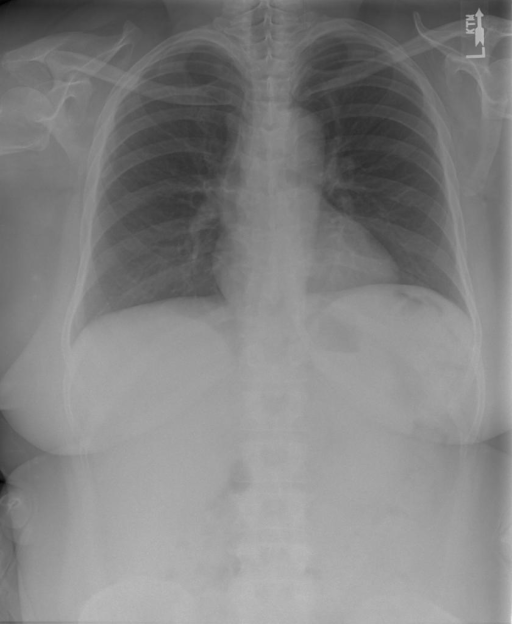

2

C:\Users\wangn\anaconda3\envs\pytorch\lib\site-packages\nltk\translate\bleu_score.py:552: UserWarning: 
The hypothesis contains 0 counts of 3-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)
C:\Users\wangn\anaconda3\envs\pytorch\lib\site-packages\nltk\translate\bleu_score.py:552: UserWarning: 
The hypothesis contains 0 counts of 4-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)
1it [00:00,  1.15it/s]

预测结果： . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . 
正确结果： stable flattening the posterior diaphragm and scattered chronic appearing irregular interstitial markings with no focal alveolar consolidation .  stable cardiomediastinal silhouette with normal heart size and aortic ectasiatortuosity stable mediastinal contours .  no definite pleural effusion seen no typical findings pulmonary edema .  following spine ossifications and marginal osteophytes again noted . 


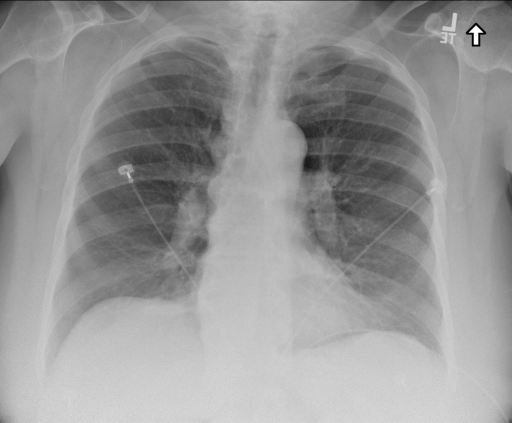

2

2it [00:01,  1.48it/s]

预测结果： . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . 
正确结果： the lungs appear clear .  the heart and pulmonary are normal .  pleural spaces are clear .  mediastinal contours are normal .  patient status post sternotomy and cabg . 


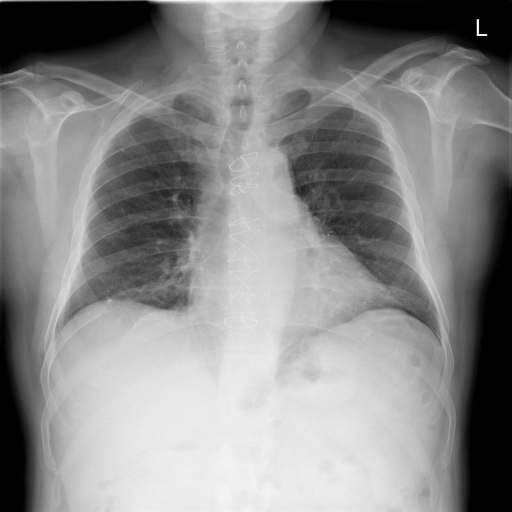

2

3it [00:01,  1.64it/s]

预测结果： . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . 
正确结果： the heart normal size .  the mediastinum within normal limits .  duallumen right catheter identified without pneumothora .  the lungs are moderately hypoinflated with bibasilar opacities adjacent atelectasis .  there illdefined density overlying the anterior left rib possibly healing deformity versus superimposition structures . 


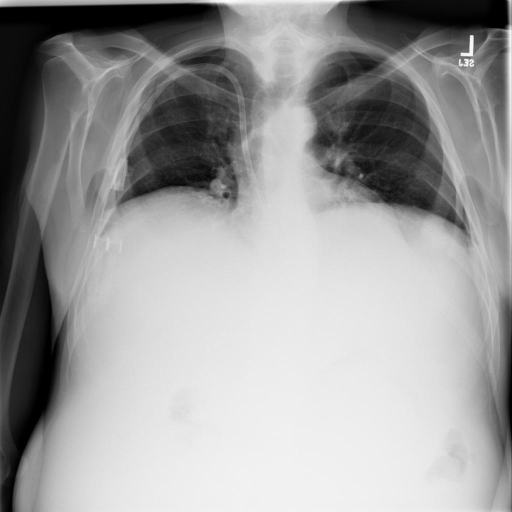

2

4it [00:02,  1.73it/s]

预测结果： . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . 
正确结果： cardiac and mediastinal silhouette are unremarkable .  lungs are clear .  no focal consolidation pneumothora pleural effusion identified .  and soft tissue are unremarkable . 


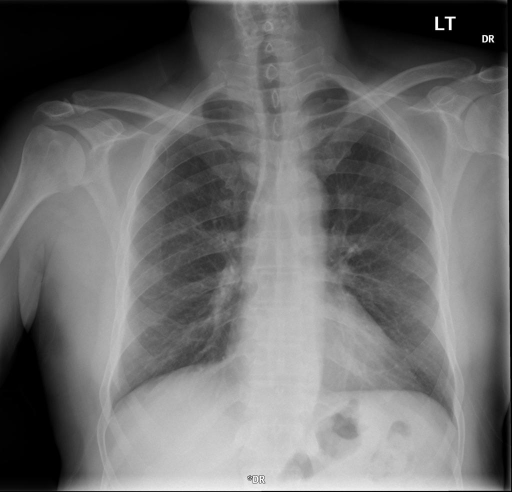

2

5it [00:03,  1.78it/s]

预测结果： . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . 
正确结果： the lungs are clear .  there no focal airspace consolidation .  no pleural effusion pneumothora .  heart size and mediastinal contour are within normal limits .  there are multilevel degenerative changes the spine . 


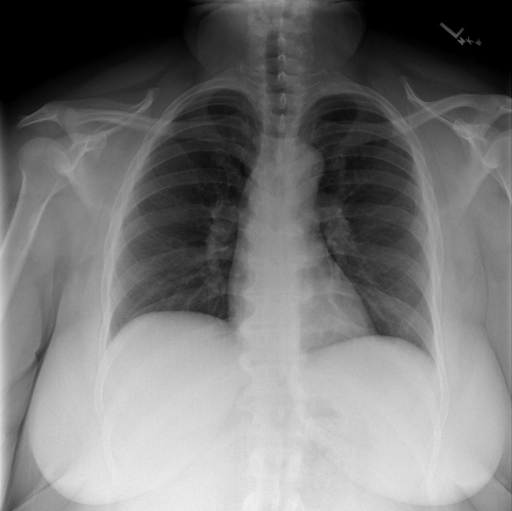

2

6it [00:03,  1.80it/s]

预测结果： . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . 
正确结果： heart size normal .  right lung clear .  granulomatous disease the bilateral .  subsegmental atelectasis the left lower lung .  no pneumothora .  no pleural effusion . 


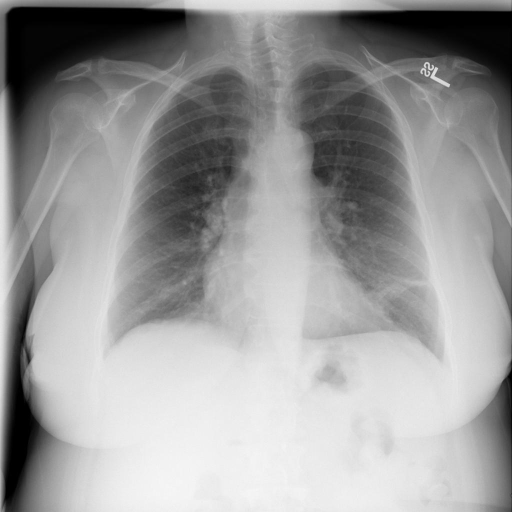

2

7it [00:04,  1.80it/s]

预测结果： . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . 
正确结果： the heart and lungs have the interval .  both lungs are clear and epanded .  heart and mediastinum normal . 


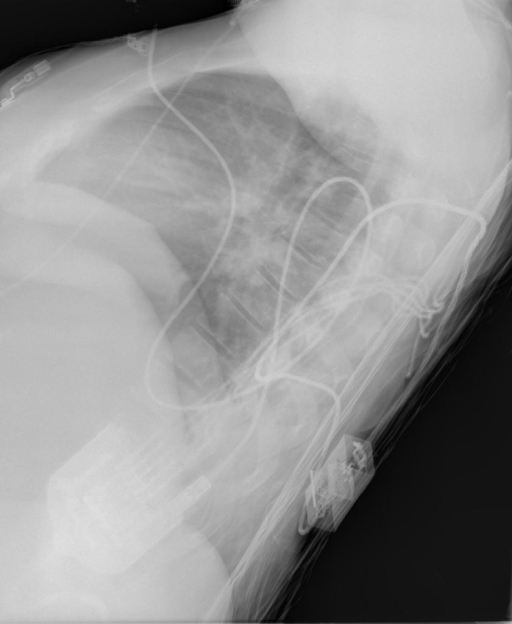

2

8it [00:04,  1.81it/s]

预测结果： . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . 
正确结果： heart size and pulmonary vascularity appear within normal limits .  lungs are free focal airspace disease .  no pleural effusion pneumothora seen . 


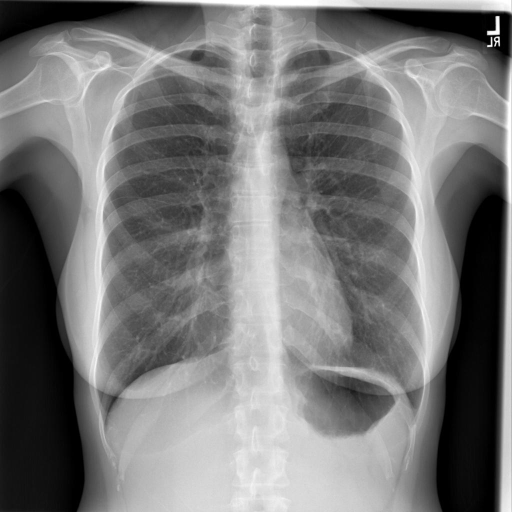

2

9it [00:05,  1.83it/s]

预测结果： . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . 
正确结果： images .  heart size upper limits normal .  mediastinal contours are maintained .  the patient mildly rotated .  there small moderate sized right apical pneumothora which measures approimately cm .  no focal airspace consolidation seen .  left chest clear .  no definite displaced bony injury seen .  results called p . m . 


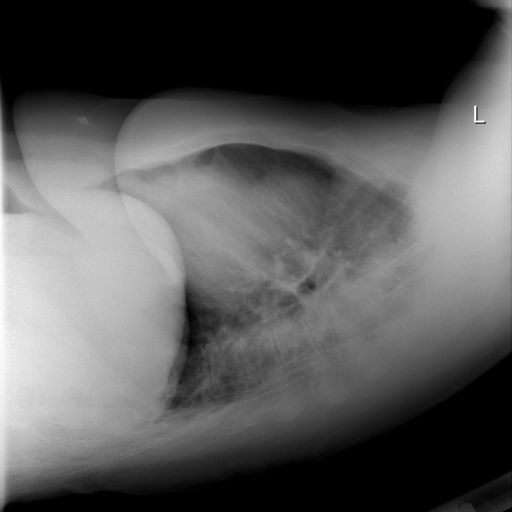

2

10it [00:05,  1.85it/s]

预测结果： . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . 
正确结果： heart size and pulmonary vascularity appear within normal limits .  the lungs are free focal airspace disease .  no pleural effusion pneumothora seen .  vascular calcification noted . 


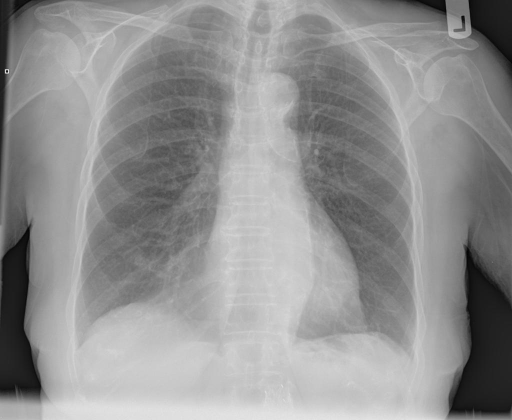

2

11it [00:06,  1.87it/s]

预测结果： . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . 
正确结果： heart size within normal limits stable mediastinal and hilar contours .  no focal alveolar consolidation no definite pleural effusion seen .  no typical findings pulmonary edema .  no pneumothora .  mild detrocurvature the spine again noted . 


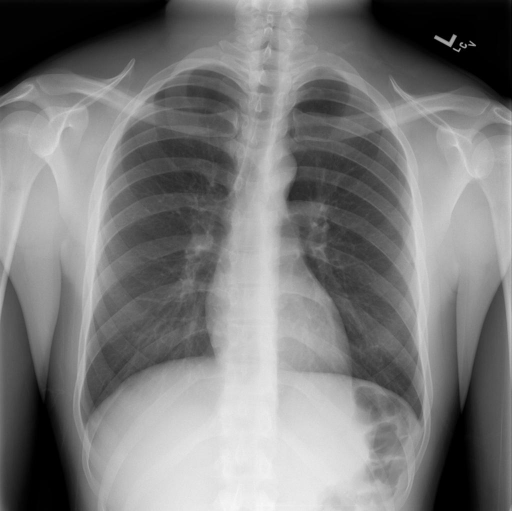

2

12it [00:06,  1.74it/s]


KeyboardInterrupt: 

In [89]:
# 验证数据集
from IPython.display import display
from PIL import Image
import numpy as np
from tqdm import tqdm

path = '../data/NLMCXR/NLMCXR_png/'
csvData = pd.read_csv('Test_Data.csv')
h5f = h5py.File('../../CLIP-out/h5/test_clip_features1.h5','r')
data = csvData.iloc[:,:]
scores = []

Beam_Size = 3
for idx,data_ in tqdm(enumerate(data.iterrows())):
    Person_id = data_[1][0]
    F_name = data_[1][1]
    F_text = data_[1][3]

    img_name = F_name.split('/')[-1]
    
    h5f_name = Person_id
    
    img_feature = np.array(h5f[h5f_name])
    
    img_path = F_name
    
    img_feature = torch.tensor(img_feature)
    
    img_feature = img_feature.to(device)
    model_pred.to(device)
    results = model_pred.generate(img_feature,beam_size=Beam_Size)

    print('预测结果：',results[Beam_Size-1])
    print('正确结果：',F_text)

    img = Image.open(img_path).convert('RGB')
    display(img, Image.BILINEAR)
    
    # 计算BLUE
    from nltk.translate.bleu_score import sentence_bleu
    reference = [F_text.split(' ')]
    candidate = results[Beam_Size-1].split(' ')
    score = sentence_bleu(reference,candidate)
    scores.append(score)

print('预测结果：',results[Beam_Size-1])
print('正确结果：',F_text)
print('BLEU:',np.mean(scores))
img = Image.open(img_path).convert('RGB')
display(img, Image.BILINEAR)

In [86]:
h5f['../data/NLMCXR/NLMCXR_png/CXR682_IM-2253_0']

KeyError: "Unable to open object (object 'CXR682_IM-2253_0' doesn't exist)"

In [85]:
h5f_name

'../data/NLMCXR/NLMCXR_png/CXR682_IM-2253_0'

In [87]:
dict

dict

In [17]:
epoch = 15
batch_size = 16
learning_rate = 5e-5

loss_img = nn.CrossEntropyLoss().to(device)
loss_txt = nn.CrossEntropyLoss().to(device)
optimizer = optim.Adam(model.parameters(), lr=learning_rate, betas=(0.9, 0.98), eps=1e-6, weight_decay=0.2)

In [18]:
def convert_models_to_fp32(model):
    for p in model.parameters():
        p.data = p.data.float()
        p.grad.data = p.grad.data.float()

In [23]:
for i in range(epoch):
    print('----[%d] epoch---' % (i + 1))
    for batch in train_loader:

        images, report, person_id = batch
        report = clip.tokenize(texts=report, truncate=True).to(device)#truncate=True截断句子
        # images = images.to(device)
        image1 = images[0].to(device)
        image2 = images[1].to(device)

        # 通过logits_per_image, logits_per_text = model(images, texts)可以得到预测结果，与torch.arange(N)计算交叉熵进行优化
        logits_per_image1, logits_per_text = model(image1, report)
        if device == "cpu":
            ground_truth = torch.arange(batch_size).long().to(device)
            print("cpu")
        else:
            ground_truth = torch.arange(batch_size, dtype=torch.long, device=device)

        # 反向传播
        total_loss = (loss_img(logits_per_image1, ground_truth) + loss_txt(logits_per_text, ground_truth)) / 2
        optimizer.zero_grad()
        total_loss.backward()
        if device == "cpu":
            optimizer.step()
        else:
            convert_models_to_fp32(model)
            optimizer.step()
            clip.model.convert_weights(model)

    print('[%d] loss: %.6f' % (i + 1, total_loss))
torch.save(model, 'D:/coding/Jupyter/CLIP-out/model1.pkl')

----[1] epoch---
[1] loss: 2.791016
----[2] epoch---
[2] loss: 2.769531
----[3] epoch---
[3] loss: 2.775391
----[4] epoch---
[4] loss: 2.777344
----[5] epoch---
[5] loss: 2.777344
----[6] epoch---
[6] loss: 2.761719
----[7] epoch---
[7] loss: 2.769531
----[8] epoch---
[8] loss: 2.773438
----[9] epoch---
[9] loss: 2.773438
----[10] epoch---
[10] loss: 2.773438
----[11] epoch---
[11] loss: 2.773438
----[12] epoch---
[12] loss: 2.773438
----[13] epoch---
[13] loss: 2.773438
----[14] epoch---
[14] loss: 2.773438
----[15] epoch---
[15] loss: 2.773438


In [88]:
word2id_dict

{'<pad>': 0,
 '<unk>': 1,
 '<start>': 2,
 '<end>': 3,
 '.': 4,
 '': 5,
 'the': 6,
 'no': 7,
 'are': 8,
 'normal': 9,
 'and': 10,
 'pleural': 11,
 'there': 12,
 'pneumothora': 13,
 'effusion': 14,
 'heart': 15,
 'lungs': 16,
 'size': 17,
 'focal': 18,
 'within': 19,
 'clear': 20,
 'limits': 21,
 'pulmonary': 22,
 'consolidation': 23,
 'silhouette': 24,
 'right': 25,
 'mediastinal': 26,
 'airspace': 27,
 'cardiomediastinal': 28,
 'left': 29,
 'acute': 30,
 'lung': 31,
 'with': 32,
 'unremarkable': 33,
 'disease': 34,
 'stable': 35,
 'spine': 36,
 'mediastinum': 37,
 'structures': 38,
 'changes': 39,
 'contours': 40,
 'thoracic': 41,
 'bony': 42,
 'contour': 43,
 'mild': 44,
 'degenerative': 45,
 'large': 46,
 'seen': 47,
 'appear': 48,
 'opacity': 49,
 'osseous': 50,
 'without': 51,
 'calcified': 52,
 'cardiac': 53,
 'effusions': 54,
 'vascularity': 55,
 'intact': 56,
 'abnormality': 57,
 'for': 58,
 'visualized': 59,
 'opacities': 60,
 'evidence': 61,
 'upper': 62,
 'lateral': 63,
 'vas

In [21]:
if hasattr(torch.cuda, 'empty_cache'):
	torch.cuda.empty_cache()

In [ ]:
for i in range(epoch):
    print('----[%d] epoch---' % (i + 1))
    for batch in train_loader:

        images, report, person_id = batch
        report = clip.tokenize(texts=report, truncate=True).to(device)#truncate=True截断句子
        # images = images.to(device)
        image1 = images[0].to(device)
        image2 = images[1].to(device)

        # 通过logits_per_image, logits_per_text = model(images, texts)可以得到预测结果，与torch.arange(N)计算交叉熵进行优化
        logits_per_image1, logits_per_text = model(image1, report)
        logits_per_image2, logits_per_text = model(image2, report)
        logits_per_image = (logits_per_image1+logits_per_image2)/2
        if device == "cpu":
            ground_truth = torch.arange(batch_size).long().to(device)
            print("cpu")
        else:
            ground_truth = torch.arange(batch_size, dtype=torch.long, device=device)

        # 反向传播
        total_loss = (loss_img(logits_per_image, ground_truth) + loss_txt(logits_per_text, ground_truth)) / 2
        optimizer.zero_grad()
        total_loss.backward()
        if device == "cpu":
            optimizer.step()
        else:
            convert_models_to_fp32(model)
            optimizer.step()
            clip.model.convert_weights(model)

    print('[%d] loss: %.6f' % (i + 1, total_loss))
torch.save(model, 'D:/coding/Jupyter/CLIP-out/model2.pkl')